In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00


In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification
import pandas as pd
import numpy as np

from datasets import load_dataset

dataset = load_dataset('xnli', 'en')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [ ]:
dataset['train']

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 392702
})

In [ ]:
train = [f"[CLS] {p} [SEP] {h} [SEP]" for p, h in zip(dataset['train']['premise'][:8000], dataset['train']['hypothesis'][:8000])]
validation = [f"[CLS] {p} [SEP] {h} [SEP]" for p, h in zip(dataset['validation']['premise'], dataset['validation']['hypothesis'])]

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    train,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256*2,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    validation,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256*2,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset['train']['label'][:8000])

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset['validation']['label'])

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 10

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 4

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

def plot_confusion_matrix(preds, labels, label_dict):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    label_to_name = {value: key for key, value in label_dict.items()}

    # Вычисляем confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)
    label_names = list(label_dict.keys()) #['Easy', 'Normal']
    #label_names = ['Very Easy', 'Easy', 'Normal', 'Hard', 'Very Hard']#[label_to_name.get(label, "Unknown") for label in np.unique(labels_flat)]

    # Визуализация confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm[::-1], annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names[::-1])
    plt.title('Confusion Matrix')
    plt.ylabel('Истинные классы')
    plt.xlabel('Предсказанные классы')
    plt.show()


def metrics_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(labels_flat, preds_flat)

    for label in np.unique(labels_flat):
        # True Positives
        TP = cm[label, label]
        # False Positives: sum of the corresponding column minus TP
        FP = np.sum(cm[:, label]) - TP
        # False Negatives: sum of the corresponding row minus TP
        FN = np.sum(cm[label, :]) - TP

        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

        tqdm.write(f'Class: {label_dict_inverse[label]}')
        tqdm.write(f'Accuracy: {TP}/{TP+FN} (True Positives / Total Actual Positives)')
        tqdm.write(f'Precision: {precision:.2f}')
        tqdm.write(f'Recall: {recall:.2f}')
        tqdm.write(f'F1 Score: {f1:.2f}\n')

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9425002801418304
Validation loss: 0.8444486473458838
F1: 0.6543714080323394


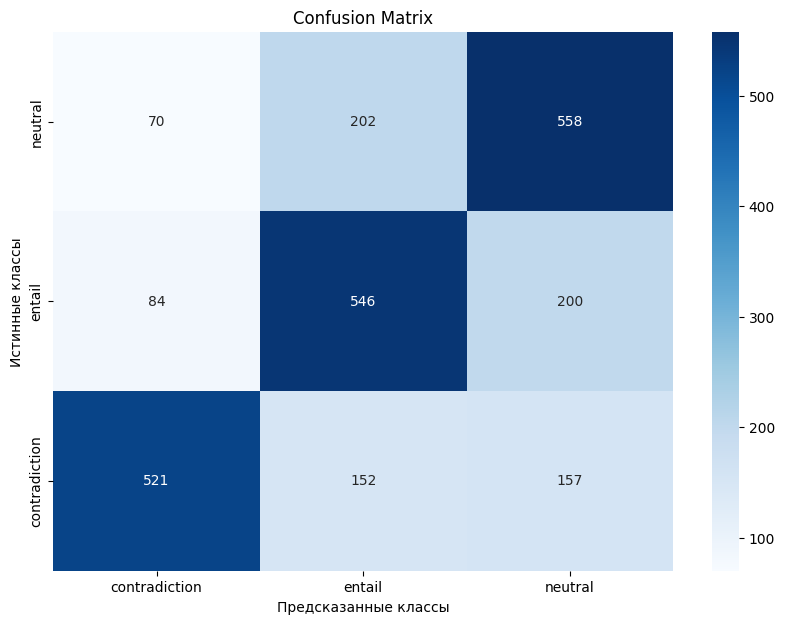

Class: contradiction
Accuracy: 521/830 (True Positives / Total Actual Positives)
Precision: 0.77
Recall: 0.63
F1 Score: 0.69

Class: entail
Accuracy: 546/830 (True Positives / Total Actual Positives)
Precision: 0.61
Recall: 0.66
F1 Score: 0.63

Class: neutral
Accuracy: 558/830 (True Positives / Total Actual Positives)
Precision: 0.61
Recall: 0.67
F1 Score: 0.64



Epoch 2:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7270360527187586
Validation loss: 0.7812468943346935
F1: 0.6671076847857831


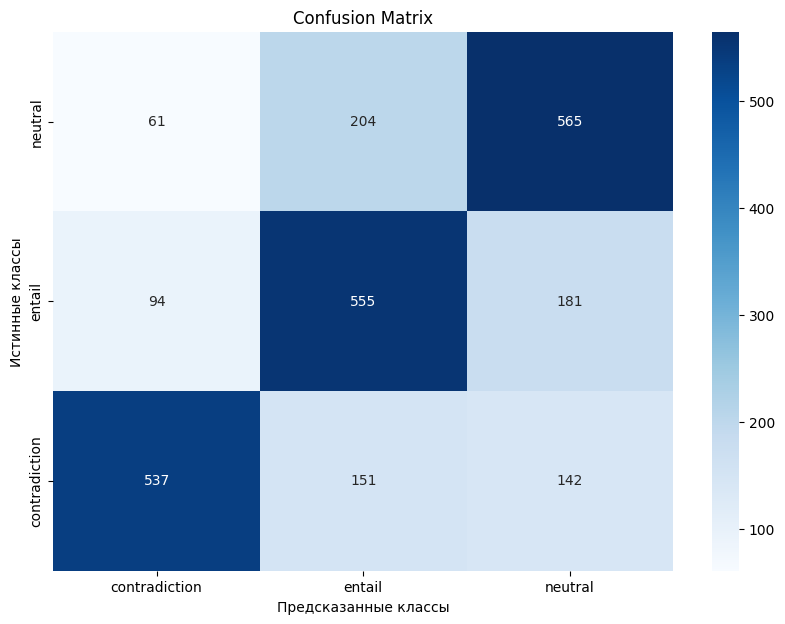

Class: contradiction
Accuracy: 537/830 (True Positives / Total Actual Positives)
Precision: 0.78
Recall: 0.65
F1 Score: 0.71

Class: entail
Accuracy: 555/830 (True Positives / Total Actual Positives)
Precision: 0.61
Recall: 0.67
F1 Score: 0.64

Class: neutral
Accuracy: 565/830 (True Positives / Total Actual Positives)
Precision: 0.64
Recall: 0.68
F1 Score: 0.66



Epoch 3:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5815267119649797
Validation loss: 0.8556802627073234
F1: 0.6681991252531109


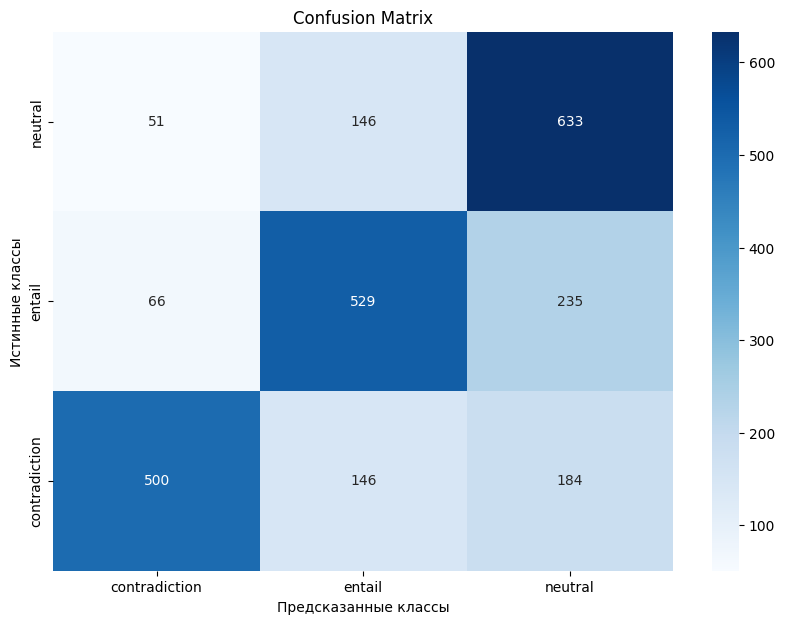

Class: contradiction
Accuracy: 500/830 (True Positives / Total Actual Positives)
Precision: 0.81
Recall: 0.60
F1 Score: 0.69

Class: entail
Accuracy: 529/830 (True Positives / Total Actual Positives)
Precision: 0.64
Recall: 0.64
F1 Score: 0.64

Class: neutral
Accuracy: 633/830 (True Positives / Total Actual Positives)
Precision: 0.60
Recall: 0.76
F1 Score: 0.67



Epoch 4:   0%|          | 0/800 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4744094081316143
Validation loss: 0.9283440800675427
F1: 0.6775183942703126


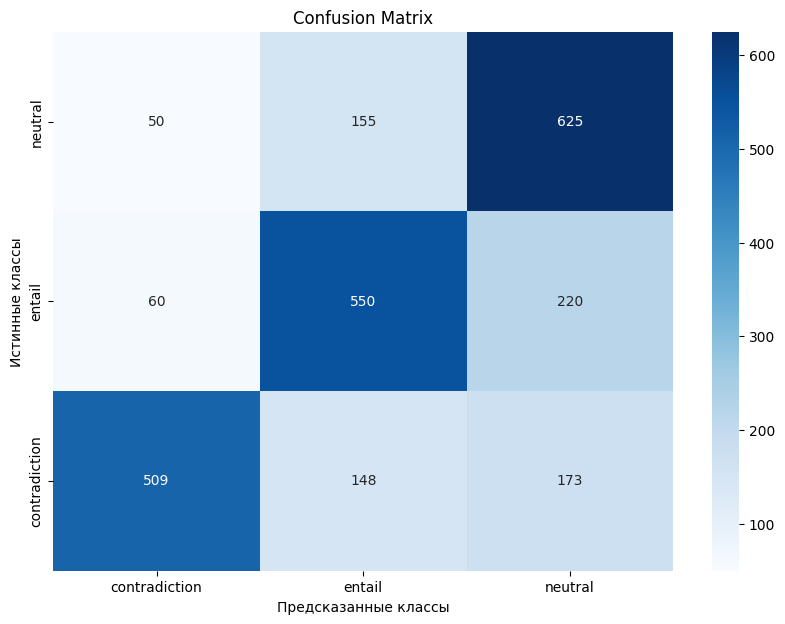

Class: contradiction
Accuracy: 509/830 (True Positives / Total Actual Positives)
Precision: 0.82
Recall: 0.61
F1 Score: 0.70

Class: entail
Accuracy: 550/830 (True Positives / Total Actual Positives)
Precision: 0.64
Recall: 0.66
F1 Score: 0.65

Class: neutral
Accuracy: 625/830 (True Positives / Total Actual Positives)
Precision: 0.61
Recall: 0.75
F1 Score: 0.68



In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = "cpu"
if torch.cuda.is_available(): device = "cuda"

model = model.to(device)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})



    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1: {val_f1}')
    #accuracy_per_class(predictions, true_vals)
    label_dict = {'contradiction': 0, 'entail': 1, 'neutral': 2} #https://github.com/yg211/bert_nli/blob/master/test_trained_model.py | str 30
    plot_confusion_matrix(predictions, true_vals, label_dict)
    metrics_per_class(predictions, true_vals, label_dict)

In [ ]:
torch.save(model.state_dict(), "./XNLI_en")

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
#                                           do_lower_case=True)

# def make_dataloader(language='en', n_samples=500):

#     label_dict = {'contradiction': 0, 'entail': 1, 'neutral': 2}

#     dataset = load_dataset('xnli', language, split='test')
#     test = [f"[CLS] {p} [SEP] {h} [SEP]" for p, h in zip(dataset['premise'], dataset['hypothesis'])][1000:n_samples+1000]

#     encoded_data_predict = tokenizer.batch_encode_plus(
#         test,
#         add_special_tokens=True,
#         return_attention_mask=True,
#         pad_to_max_length=True,
#         max_length=256*2,
#         return_tensors='pt'
#     )

#     input_ids_predict = encoded_data_predict['input_ids']
#     attention_masks_predict = encoded_data_predict['attention_mask']
#     labels_predict = torch.tensor(dataset['label'][1000:n_samples+1000])

#     dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)


#     batch_size = 3

#     return DataLoader(dataset_predict,
#                                   sampler=SequentialSampler(dataset_predict),
#                                   batch_size=batch_size)

In [ ]:
import os
from torch.utils.data import DataLoader, SequentialSampler

os.system("""wget "https://getfile.dokpub.com/yandex/get/https://disk.yandex.com/d/_PuirqYsyj4sLw" -O model_en""")

0

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
stete_dict = torch.load("./model_en", map_location='cpu')
model.load_state_dict(stete_dict)

device = "cpu"
if torch.cuda.is_available(): device = "cuda"

model = model.to(device)

In [ ]:
import random

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased',
                                          do_lower_case=True)

def make_dataloader(dataset, n_samples=500):
    label_dict = {'contradiction': 0, 'entail': 1, 'neutral': 2}

    # Загрузка датасета
    # dataset = load_dataset('xnli', language, split='test')

    # Получение размера датасета
    dataset_size = len(dataset['label'])

    # Генерация случайных уникальных индексов для выборки
    random_indices = random.sample(range(dataset_size), n_samples)

    # Выборка данных по случайным индексам
    test = [f"[CLS] {dataset['premise'][i]} [SEP] {dataset['hypothesis'][i]} [SEP]" for i in random_indices]

    encoded_data_predict = tokenizer.batch_encode_plus(
        test,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    input_ids_predict = encoded_data_predict['input_ids']
    attention_masks_predict = encoded_data_predict['attention_mask']
    labels_predict = torch.tensor([dataset['label'][i] for i in random_indices])

    dataset_predict = TensorDataset(input_ids_predict, attention_masks_predict, labels_predict)

    batch_size = 3

    return DataLoader(dataset_predict, sampler=SequentialSampler(dataset_predict), batch_size=batch_size)


In [ ]:
def get_neurons_activations(dataloader):
    model.eval()

    # Подготовка списка для хранения усредненных скрытых состояний по слоям
    avg_hidens_per_layer = [[] for _ in range(13)]  # предполагается, что у модели 12 слоев + входной слой

    for batch in dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        # Создание маски для исключения [PAD] токенов (где input_ids равно 0)
        mask = inputs['input_ids'] != 0  # Создается маска размером как input_ids, True где не PAD
        mask = mask.unsqueeze(-1).expand_as(outputs['hidden_states'][0])  # Расширение маски до размера скрытых состояний

        for layer_idx, layer_hidden_states in enumerate(outputs['hidden_states']):
            # Применение маски к скрытым состояниям
            masked_hidden_states = layer_hidden_states * mask.float()
            # Вычисление суммы и количества не-pad токенов для усреднения
            sum_hidden_states = masked_hidden_states.sum(dim=1)  # Сумма по оси токенов
            non_pad_tokens = mask.sum(dim=1)  # Количество не-pad токенов
            # Усреднение скрытых состояний, исключая pad-токены
            avg_hidden_states = sum_hidden_states / non_pad_tokens.clamp(min=1)  # Избегание деления на 0
            avg_hidens_per_layer[layer_idx].append(avg_hidden_states)

    # Собираем усредненные скрытые состояния по всему датасету для каждого слоя
    avg_hidens_stacked_per_layer = [torch.cat(layer_avg_hidens, dim=0) for layer_avg_hidens in avg_hidens_per_layer]

    # Стекинг усредненных скрытых состояний для всех слоев
    all_avg_hidens_tensor = torch.stack(avg_hidens_stacked_per_layer)

    return all_avg_hidens_tensor # [layers, batch, neurons]


In [ ]:
def pearson_corr(x, y):

    return (torch.dot(x, y)/(torch.norm(x)*torch.norm(y))).item()

def ANC(L1, L2):
    X = L1 - L1.mean(dim=0, keepdim=True)
    Y = L2 - L2.mean(dim=0, keepdim=True)

    anc = 0
    for i in range(X.size()[0]):
        anc+=abs(pearson_corr(X[i], Y[i]))

    return anc/X.size()[0]

def count_ANC(layers1, layers2):
    anc = []
    for i in range(13):
        anc.append(ANC(layers1[i], layers2[i]))

    return anc

In [ ]:
dataloader_en = make_dataloader(load_dataset('xnli', 'en', split='test'))
layers_en = get_neurons_activations(dataloader_en)
torch.cuda.empty_cache()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

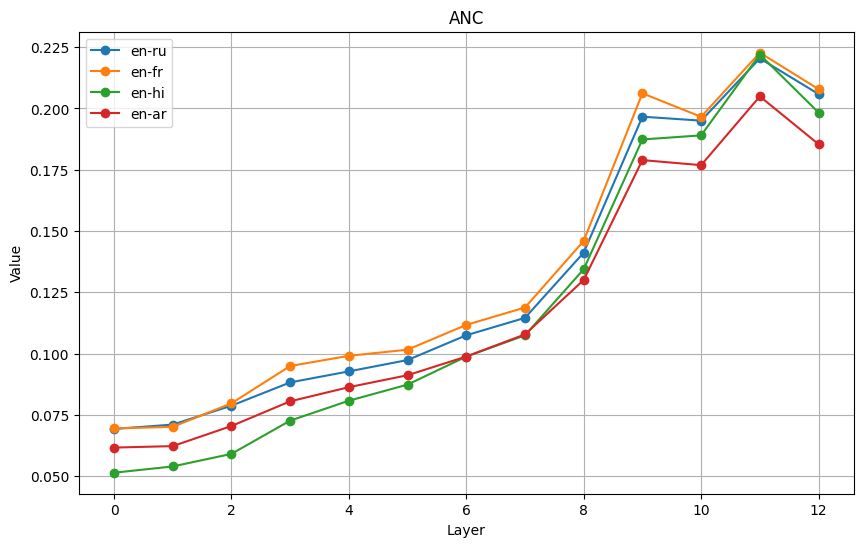

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(0, 13)

plt.figure(figsize=(10, 6))

languages = ['ru', 'fr', 'hi', 'ar']

for lang in languages:
    dataloader_compare = make_dataloader(load_dataset('xnli', lang, split='test'))
    layers_compare = get_neurons_activations(dataloader_compare)
    torch.cuda.empty_cache()

    ANC_counted = count_ANC(layers_en, layers_compare)

    plt.plot(x, ANC_counted, label=f'en-{lang}', marker='o')

plt.title('ANC')
plt.xlabel('Layer')
plt.ylabel('Value')
plt.legend()

plt.grid(True)
plt.show()


In [ ]:
data = []
languages = ['ru', 'fr', 'hi', 'ar']

for lang in languages:
    dataset_compare = load_dataset('xnli', lang, split='test')
    for i in range(10):
        dataloader_compare = make_dataloader(dataset_compare)
        layers_compare = get_neurons_activations(dataloader_compare)
        torch.cuda.empty_cache()

        ANC_counted = count_ANC(layers_en, layers_compare)

        data.append({
            'Value': ANC_counted,
            'Language Pair': f'en-{lang}'
        })

df = pd.DataFrame(data)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
df.head()

,Value,Language Pair
0,"[0.06790169362770393, 0.0693320377956834, 0.07...",en-ru
1,"[0.06725362032194972, 0.07014783170784358, 0.0...",en-ru
2,"[0.06669741411446012, 0.06699879758019234, 0.0...",en-ru
3,"[0.0659676945062547, 0.06811746631364804, 0.07...",en-ru
4,"[0.06422451151099813, 0.06554882170991914, 0.0...",en-ru


In [ ]:
df.to_csv(f'ANC_XNLI.txt', index=False, sep=';')

In [ ]:
def eval_prediction(dataloader):
    label_dict = {'contradiction': 0, 'entail': 1, 'neutral': 2}

    predict_loss, predictions, true_predict = evaluate(dataloader)
    predict_f1 = f1_score_func(predictions, true_predict)
    print(f'Predictions loss: {predict_loss}')
    print(f'F1 Score (Weighted): {predict_f1}')
    plot_confusion_matrix(predictions, true_predict, label_dict)
    metrics_per_class(predictions, true_predict, label_dict)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions loss: 0.9956333817032996
F1 Score (Weighted): 0.5505320679212632


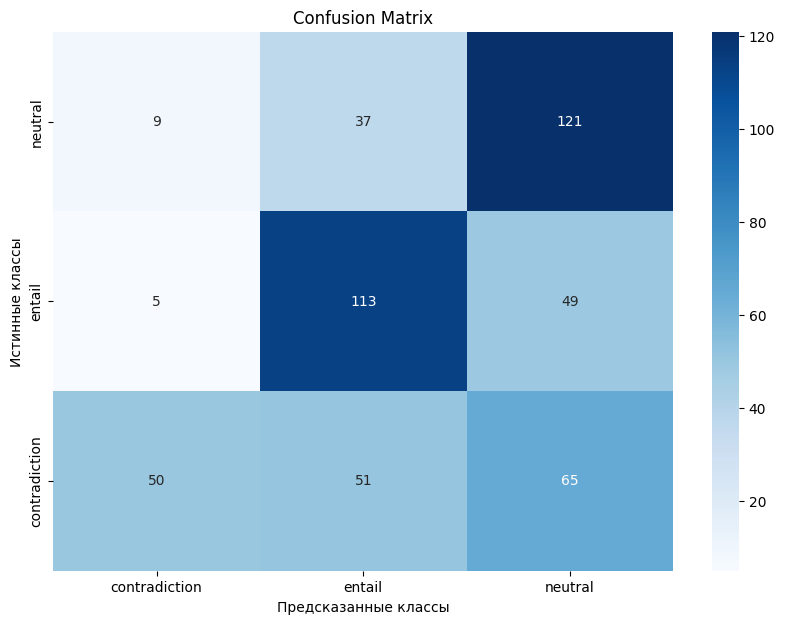

Class: contradiction
Accuracy: 50/166 (True Positives / Total Actual Positives)
Precision: 0.78
Recall: 0.30
F1 Score: 0.43

Class: entail
Accuracy: 113/167 (True Positives / Total Actual Positives)
Precision: 0.56
Recall: 0.68
F1 Score: 0.61

Class: neutral
Accuracy: 121/167 (True Positives / Total Actual Positives)
Precision: 0.51
Recall: 0.72
F1 Score: 0.60



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions loss: 0.9348441166524402
F1 Score (Weighted): 0.587617070008643


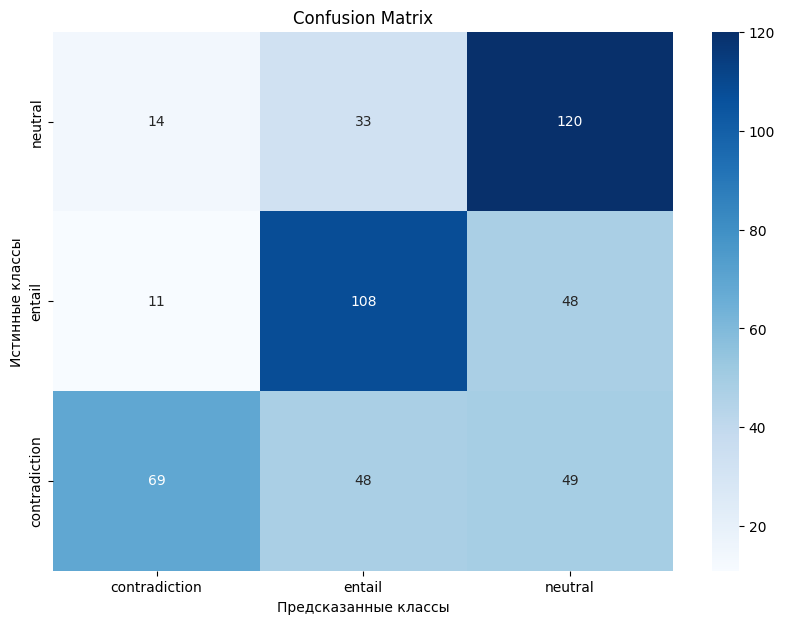

Class: contradiction
Accuracy: 69/166 (True Positives / Total Actual Positives)
Precision: 0.73
Recall: 0.42
F1 Score: 0.53

Class: entail
Accuracy: 108/167 (True Positives / Total Actual Positives)
Precision: 0.57
Recall: 0.65
F1 Score: 0.61

Class: neutral
Accuracy: 120/167 (True Positives / Total Actual Positives)
Precision: 0.55
Recall: 0.72
F1 Score: 0.62



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions loss: 1.1061648209830244
F1 Score (Weighted): 0.43716326371268655


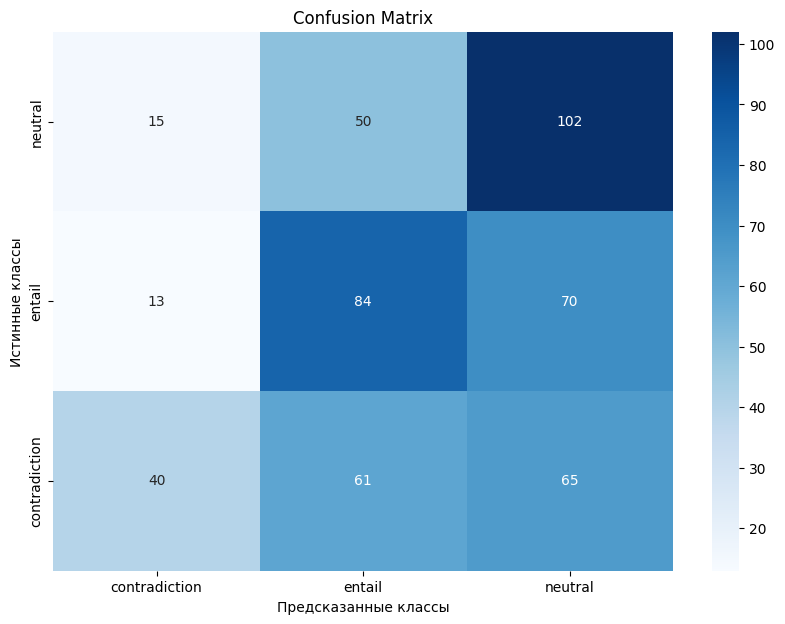

Class: contradiction
Accuracy: 40/166 (True Positives / Total Actual Positives)
Precision: 0.59
Recall: 0.24
F1 Score: 0.34

Class: entail
Accuracy: 84/167 (True Positives / Total Actual Positives)
Precision: 0.43
Recall: 0.50
F1 Score: 0.46

Class: neutral
Accuracy: 102/167 (True Positives / Total Actual Positives)
Precision: 0.43
Recall: 0.61
F1 Score: 0.50



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Predictions loss: 1.0458055808694062
F1 Score (Weighted): 0.5195874491330462


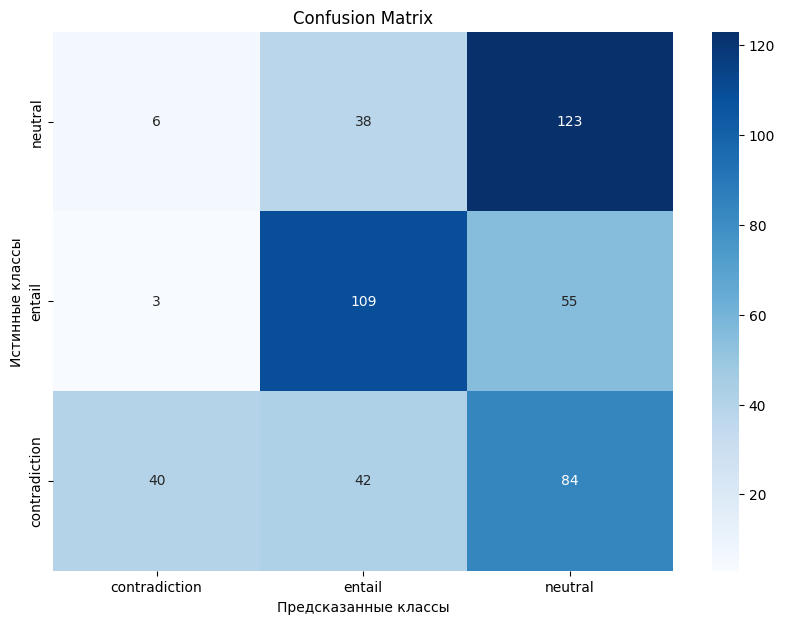

Class: contradiction
Accuracy: 40/166 (True Positives / Total Actual Positives)
Precision: 0.82
Recall: 0.24
F1 Score: 0.37

Class: entail
Accuracy: 109/167 (True Positives / Total Actual Positives)
Precision: 0.58
Recall: 0.65
F1 Score: 0.61

Class: neutral
Accuracy: 123/167 (True Positives / Total Actual Positives)
Precision: 0.47
Recall: 0.74
F1 Score: 0.57



In [ ]:
for lang in ['ru', 'fr', 'hi', 'ar']:
    print(lang)
    dataloader = make_dataloader(lang)
    eval_prediction(dataloader)